# Monge-Ampère equations

In [1]:

import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation.Optimization import newton_root

In [2]:

x = np.stack(np.meshgrid(*(2 * [np.linspace(-1, 1, 100)]), indexing="ij"))

superbases = Selling.SuperbasesForConditioning(15)

## 1. The discretized equation

In [3]:


def MA(u, B, bc, superbases):
    superbases = np.multiply.outer(superbases, np.ones(u.shape, dtype=np.int64))

    b = B(bc.grid, u)

    residue = -np.inf

    d2u = bc.Diff2(u, lp.perp(superbases))

    W = (
        -np.stack(
            [
                np.roll(superbases[0], 1, axis=0) * np.roll(superbases[0], 2, axis=0)
                - np.roll(superbases[1], 1, axis=0) * np.roll(superbases[1], 2, axis=0),
                np.roll(superbases[0], 1, axis=0) * np.roll(superbases[1], 2, axis=0)
                + np.roll(superbases[1], 1, axis=0) * np.roll(superbases[0], 2, axis=0),
            ]
        )
        / 2
    )
    w = -lp.dot_VV(np.roll(superbases, 1, axis=1), np.roll(superbases, 2, axis=1)) / 2

    q = lp.dot_AV(W, d2u)
    r = np.sqrt(b + lp.dot_VV(q, q))

    residue = np.maximum(
        residue,
        np.max(
            np.where(
                np.all(lp.dot_VA(q, W) <= r * w, axis=0),
                r - lp.dot_VV(w, d2u),
                -np.inf,
            ),
            axis=0,
        ),
    )

    bases = np.concatenate(
        [superbases[:, [0, 1]], superbases[:, [0, 2]], superbases[:, [1, 2]]], axis=2
    )
    d2u_bases = np.concatenate([d2u[[0, 1]], d2u[[0, 2]], d2u[[1, 2]]], axis=1)

    residue = np.maximum(
        residue,
        np.max(
            np.sqrt(
                b
                * lp.det(bases) ** 2
                / (
                    lp.dot_VV(bases[:, 0], bases[:, 0])
                    * lp.dot_VV(bases[:, 1], bases[:, 1])
                )
                + (
                    d2u_bases[0] / lp.dot_VV(bases[:, 0], bases[:, 0])
                    - d2u_bases[1] / lp.dot_VV(bases[:, 1], bases[:, 1])
                )
                ** 2
                / 4
            )
            - (
                d2u_bases[0] / lp.dot_VV(bases[:, 0], bases[:, 0])
                + d2u_bases[1] / lp.dot_VV(bases[:, 1], bases[:, 1])
            )
            / 2,
            axis=0,
        ),
    )

    return residue

## 2. Dirichlet boundary conditions

In [4]:


def SchemeDirichlet(u, B, bc, superbases):
    return np.where(bc.interior, MA(u, B, bc, superbases), u - bc.grid_values)

/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in less_equal
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in greater
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in less_equal
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in greater
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


Iteration: 1  Residue norm: 3.8923205646025547


Iteration: 2  Residue norm: 1.2872701009837755


Iteration: 3  Residue norm: 0.15508821829617014


Iteration: 4  Residue norm: 0.07236370901154093


Iteration: 5  Residue norm: 0.00892514430203839


Iteration: 6  Residue norm: 0.0005930582622555303


Iteration: 8  Residue norm: 9.136935652520606e-11
Target residue reached. Terminating.


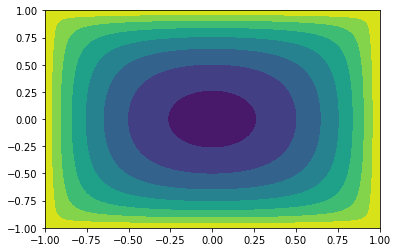

In [5]:


def B(x, r):
    return np.ones(x.shape[1:])


bc = Domain.Dirichlet(Domain.Box([[-1, 1], [-1, 1]]), 0.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (B, bc, superbases))

plt.contourf(*x, u)
plt.show()

### 2.1. Comparison with the exact solution

Iteration: 1  Residue norm: 440.3294897201366


Iteration: 2  Residue norm: 15.173489423368501


Iteration: 3  Residue norm: 4.502326835604438


Iteration: 4  Residue norm: 0.5112007534381355


Iteration: 5  Residue norm: 0.02431873069517998


Iteration: 6  Residue norm: 6.320696449257923e-05


Iteration: 7  Residue norm: 4.0591174865767243e-10
Target residue reached. Terminating.


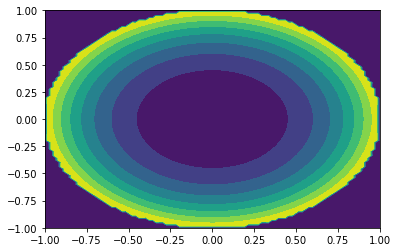

Error: 0.00046007138930027154


In [6]:


def B(x, r):
    return 4 + 32 * lp.dot_VV(x, x) + 48 * lp.dot_VV(x, x) ** 2


bc = Domain.Dirichlet(Domain.Ball(), 2.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (B, bc, superbases))

plt.contourf(*x, u)
plt.show()


def ExactQuartic(x):
    return lp.dot_VV(x, x) + lp.dot_VV(x, x) ** 2


err = np.where(bc.interior, u - ExactQuartic(x), 0)
print("Error:", np.max(np.abs(err)))

### 2.2. Other domains

Iteration: 1  Residue norm: 3.791943963628798


Iteration: 2  Residue norm: 1.1243754556408612


Iteration: 3  Residue norm: 0.14073444491339732


Iteration: 4  Residue norm: 0.04313700837978385


Iteration: 5  Residue norm: 0.00420841762238755


Iteration: 6  Residue norm: 6.915842973143072e-05


Iteration: 8  Residue norm: 5.895284260759581e-13
Target residue reached. Terminating.


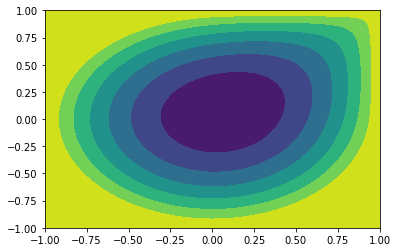

In [7]:


def B(x, r):
    return np.ones(x.shape[1:])


bc = Domain.Dirichlet(Domain.Union(Domain.Ball(), Domain.Box()), 0.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (B, bc, superbases))

plt.contourf(*x, u)
plt.show()

Iteration: 1  Residue norm: 42.75527340343402


Iteration: 2  Residue norm: 147.8676508983342


Iteration: 3  Residue norm: 103.55434260303394


Iteration: 4  Residue norm: 17.479988009476486


Iteration: 5  Residue norm: 0.6784819067407497


Iteration: 6  Residue norm: 5.98286705703884


Iteration: 8  Residue norm: 0.4037764796193133


Iteration: 10  Residue norm: 0.06553648664526313


Iteration: 12  Residue norm: 0.00042153997258154163


Iteration: 14  Residue norm: 9.101608355877033e-13
Target residue reached. Terminating.


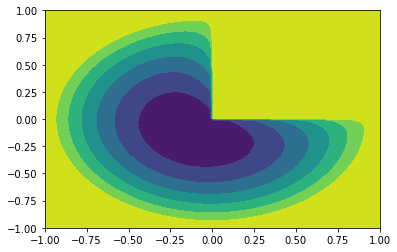

In [8]:


def B(x, r):
    return np.ones(x.shape[1:])


bc = Domain.Dirichlet(Domain.Complement(Domain.Ball(), Domain.Box()), 0.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (B, bc, superbases))

plt.contourf(*x, u)
plt.show()

## 3. Optimal transport boundary conditions

In [9]:


class BV2(Domain.Dirichlet):
    def __init__(self, domain, grid):
        super().__init__(domain, np.inf, grid)

    def DiffUpwind(self, u, offsets, reth=False):
        du = super().DiffUpwind(u, offsets)

        du = np.where(du == np.inf, np.sqrt(lp.dot_VV(offsets, offsets)), du)

        if reth:
            return du, self.gridscale
        else:
            return du

In [10]:


def SchemeBV2(u, B, bc, superbases):
    return np.where(
        bc.interior,
        MA(u, B, bc, superbases) + u.flatten()[np.argmin(bc.domain.level(bc.grid))],
        u - bc.grid_values,
    )

### 3.1. Comparison with the exact solution

Iteration: 1  Residue norm: 2069.1625072448423


Iteration: 2  Residue norm: 109.17028894899991


Iteration: 3  Residue norm: 37.0876350390643


Iteration: 4  Residue norm: 9.488205730153211


Iteration: 5  Residue norm: 3.1017757422972045


Iteration: 6  Residue norm: 0.5158981153493198


Iteration: 8  Residue norm: 0.00010778023492865468


Iteration: 9  Residue norm: 8.353138049310704e-09
Target residue reached. Terminating.


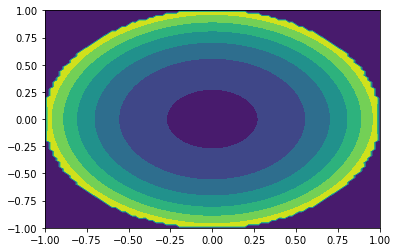

Error: 0.0692501375889793


In [11]:


def B(x, r):
    return (4 + 32 * lp.dot_VV(x, x) + 48 * lp.dot_VV(x, x) ** 2) / 36


bc = BV2(Domain.Ball(), x)

u = newton_root(SchemeBV2, np.zeros(x.shape[1:]), (B, bc, superbases))

plt.contourf(*x, u)
plt.show()


def ExactQuartic(x):
    return (lp.dot_VV(x, x) + lp.dot_VV(x, x) ** 2) / 6


err = np.where(bc.interior, u - ExactQuartic(x), 0)
print("Error:", np.max(np.abs(err)))